<h1><center>Text Analysis of Siddhartha by Hermann Hesse</center></h1>

# Goal: Learn German
I want to learn German and it is easier to measure progress and keep motivation up if the goal is defined more specifically. "Learning German" is too vague. One of my favorite authors is German so I decided to make the goal reading one of his books in the original. I chose Siddhartha by Hermann Hesse because it is short, the writing is relatively simple, and it is available for free from Project Gutenberg (https://www.gutenberg.org/).

This will be a simple text analysis to create and prioritize a vocabulary list. I will do a frequency count for each word in the book and learn the most common words first. The words will be grouped according to the proportion of the text they make up. For example, the most frequent words that account for 50% of the text will make up the first set of vocabulary words. This means that once I learn those words I will be able to understand half of the words in the text and hopefully I will be able to start learning words from their context instead of through rote memorization with flash cards.

In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import re
import string
import requests
from bs4 import BeautifulSoup

# Make Pandas display floats to 2 decimal places while maintaining the true value
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
# Just making the plots look better
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 12
mpl.rcParams["font.family"] = "Times New Roman"

# Data Prep
At first I looked for a full German to English dictionary but the file was large and slow. I decided to use a list of the 1000 most common German words found at http://1000mostcommonwords.com/1000-most-common-german-words/ as a start. I can always go dig up more if needed.

After running into an encoding error while trying to load directly using Pandas read_table() I loaded it as a string and made some modifications before converting it into a DataFrame. It is a tab delimited file with columns "Number", "German", and "English". The "Number" column is just an index so it will be dropped. The "German" and "English" word pairs will be put into a list and converted to a Pandas DataFrame.

In [2]:
text = open('C:/Users/brend/Documents/datasets/1000GermanWords.txt', 'r+').read()
text.encode('utf-8').strip()
tn = text.split('\n')
ts = []
for row in tn:
    ts.append(row.split('\t'))
dictionary_1000 = pd.DataFrame(ts[1:], columns=ts[0]).drop(["Number"], axis=1)

I'll load the text into a string and remove all the unnecessary bits like punctuation. Then I'll split the string into a list of words.

In [3]:
#load and clean Siddhartha text and convert all to lowercase
sid_text = open('C:/Users/brend/Documents/datasets/siddhartha (german).txt').read().lower()

#remove all punctuation
translator = str.maketrans('','',string.punctuation)
sid = sid_text.translate(translator)

#split on whitespace and delete empty strings
sid_list = re.split('\s', sid)
sid_list = list(filter(None, sid_list))


# Exploration
In this step I want to summarize the data with word counts. Then I'll use those counts to find percentages so I know how many words I'll need to memorize. I think learning the vocab making up 50% of the book would be a good place to start. 

In [4]:
# create a Pandas DF and count the frequency of each word in the book
sidDF = pd.DataFrame({'words':sid_list})
sid_counts = sidDF.words.value_counts().to_frame().rename(columns={'words':'Count'})

# add a percentage column representing the % of total words accounted for by the given word
# add a cumulative percentage column to help find the right cutoff of vocab words
total_words = sid_counts.sum()[0]
sid_counts["Percentage"] = sid_counts["Count"]/total_words
sid_counts['Cumulative %'] = sid_counts['Percentage'].cumsum()

# add rank column in descending order - the most common word is number 1
sid_counts["Rank"] = sid_counts["Count"].rank(ascending=False).astype(int)

# move German vocab from the index to their own column
sid_counts["German Words"] = sid_counts.index

# create an Index column and make it the new index
sid_counts["Index"] = list(range(sid_counts["German Words"].count()))
sid_counts = sid_counts.set_index("Index")

# check the table to make sure it is turning out right
sid_counts.head(10)

,Count,Percentage,Cumulative %,Rank,German Words
Index,,,,,
0,1348,0.04,0.04,1,und
1,920,0.03,0.07,2,er
2,706,0.02,0.09,3,der
3,548,0.02,0.10,4,zu
4,506,0.01,0.12,5,die
5,487,0.01,0.13,6,ich
6,466,0.01,0.14,7,in
7,430,0.01,0.16,8,nicht
8,390,0.01,0.17,9,den


The total number of unique words in Siddhartha is 5068.


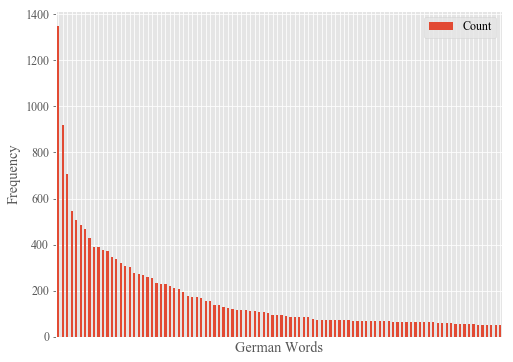

In [5]:
sid_counts[["German Words","Count"]].head(100).plot.bar()
mpl.pyplot.xlabel("German Words")
mpl.pyplot.ylabel("Frequency")
mpl.pyplot.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

print("The total number of unique words in Siddhartha is " + str(sid_counts["German Words"].count()) + ".")

The graph above is encouraging from a language learner's perspective because the heavy skew means that the 100 most common words make up a large proportion of the total words in the book. The 100 most common words are a small percentage of the more than 5000 unique words in the book but they account for a large percentage of total words in the book. Next I'm going to find out how many words I need to learn to understand 50% or more of the book.

In [6]:
#how many words do I need to learn to cover 50%, 80% of the text?
print("To read 50% of the book I need to learn "+str((sid_counts["Cumulative %"] < 0.50).sum())+" words.")
print("To read 80% of the book I need to learn "+str((sid_counts["Cumulative %"] < 0.80).sum())+" words.")

To read 50% of the book I need to learn 94 words.
To read 80% of the book I need to learn 792 words.


Nice! It looks like the top 100 words are a great place to start. I'll be able to read more than 50% of the book once I learn those first 100 vocab words. The next step is a little discouraging though. To understand 80% of the book I'll need to learn another 700 words. Hopefully by that point I'll be able to start learning words by their context instead of drilling 1000+ flashcards. 

# Create Translated Column
Now I am going to create an English Words column using the common German words table created earlier. Since there are only 1000 words in the German to English DataFrame and there are over 5000 unique words in the book, there will be, at most, matches for 20% of the words. Hopefully there are matches for the 100 most common words.

In [7]:
translations_1000 = pd.merge(sid_counts, dictionary_1000, how='left', left_on="German Words", right_on="German").drop("German", axis=1)
translations_1000.head(25)

,Count,Percentage,Cumulative %,Rank,German Words,English
0,1348,0.04,0.04,1,und,and
1,920,0.03,0.07,2,er,he
2,706,0.02,0.09,3,der,NaN
3,548,0.02,0.10,4,zu,to
4,548,0.02,0.10,4,zu,too
5,506,0.01,0.12,5,die,the
6,506,0.01,0.12,5,die,which
7,506,0.01,0.12,5,die,who
8,487,0.01,0.13,6,ich,I
9,466,0.01,0.14,7,in,NaN


It looks like there are a lot of missing values. Let's see how many missing values are in the 100 most frequent words.

In [8]:
top100 = translations_1000.head(100)
top100.count()

Count           100
Percentage      100
Cumulative %    100
Rank            100
German Words    100
English          65
dtype: int64

There are 35 missing English translations. Let's see which words are missing values and if we can do better with a larger list of German to English translations.



In [9]:
missing_words = top100[top100["English"].isnull()]
missing_words

,Count,Percentage,Cumulative %,Rank,German Words,English
2,706,0.02,0.09,3,der,NaN
9,466,0.01,0.14,7,in,NaN
11,390,0.01,0.17,9,den,NaN
13,377,0.01,0.19,11,das,NaN
14,372,0.01,0.20,12,siddhartha,NaN
16,337,0.01,0.22,14,du,NaN
21,304,0.01,0.25,17,sich,NaN
29,257,0.01,0.29,22,ihn,NaN
38,211,0.01,0.32,27,dem,NaN
39,208,0.01,0.33,28,daß,NaN


A few of the missing values are character names, which makes sense. Most of the remaining missing values are common words like "have", "his", am", "speak" which is odd. I'll try again with a longer list of vocab translations.

# Getting Vocab Translations
I couldn't find any 'ready made' lists of more than 1000 words online so I scraped the lists from https://www.memrise.com/course/920/5000-german-words-top-87/ which broke the top 5000 most common German words into lists of 25 words each.

There are 202 separate lists on 202 separate pages. Luckily, the pages follow a simple pattern,
* https://www.memrise.com/course/920/5000-german-words-top-87/1/ is the first list
* https://www.memrise.com/course/920/5000-german-words-top-87/2/ is the second list

... and so on.

So I will be able to loop through the pages easily and extract the relevant vocab word pairs.


In [28]:
# create an empty list to store vocab words
vocab = []

# iterate through the 202 pages
for i in range(202):
    page = "https://www.memrise.com/course/920/5000-german-words-top-87/"+str(i+1)+'/'
    print(page)
    
    raw_html = requests.get(page).text
    html = BeautifulSoup(raw_html, 'html.parser')
    
    # store vocab in temp list for each page
    vocab_list = []
    for div in html.find_all('div'):
        if div['class'] == ['text']:
            vocab_list.append(div.string.extract())
            #print(div.string.extract())
    
    # list to store vocab from all pages          
    for word in vocab_list:
        vocab.append(word)

https://www.memrise.com/course/920/5000-german-words-top-87/1/
https://www.memrise.com/course/920/5000-german-words-top-87/2/
https://www.memrise.com/course/920/5000-german-words-top-87/3/
https://www.memrise.com/course/920/5000-german-words-top-87/4/
https://www.memrise.com/course/920/5000-german-words-top-87/5/
https://www.memrise.com/course/920/5000-german-words-top-87/6/
https://www.memrise.com/course/920/5000-german-words-top-87/7/
https://www.memrise.com/course/920/5000-german-words-top-87/8/
https://www.memrise.com/course/920/5000-german-words-top-87/9/
https://www.memrise.com/course/920/5000-german-words-top-87/10/
https://www.memrise.com/course/920/5000-german-words-top-87/11/
https://www.memrise.com/course/920/5000-german-words-top-87/12/
https://www.memrise.com/course/920/5000-german-words-top-87/13/
https://www.memrise.com/course/920/5000-german-words-top-87/14/
https://www.memrise.com/course/920/5000-german-words-top-87/15/
https://www.memrise.com/course/920/5000-german-wo

https://www.memrise.com/course/920/5000-german-words-top-87/129/
https://www.memrise.com/course/920/5000-german-words-top-87/130/
https://www.memrise.com/course/920/5000-german-words-top-87/131/
https://www.memrise.com/course/920/5000-german-words-top-87/132/
https://www.memrise.com/course/920/5000-german-words-top-87/133/
https://www.memrise.com/course/920/5000-german-words-top-87/134/
https://www.memrise.com/course/920/5000-german-words-top-87/135/
https://www.memrise.com/course/920/5000-german-words-top-87/136/
https://www.memrise.com/course/920/5000-german-words-top-87/137/
https://www.memrise.com/course/920/5000-german-words-top-87/138/
https://www.memrise.com/course/920/5000-german-words-top-87/139/
https://www.memrise.com/course/920/5000-german-words-top-87/140/
https://www.memrise.com/course/920/5000-german-words-top-87/141/
https://www.memrise.com/course/920/5000-german-words-top-87/142/
https://www.memrise.com/course/920/5000-german-words-top-87/143/
https://www.memrise.com/c

The data was listed with a new word on each line alternating between the German word and it's English translation. I created the function below to create a DataFrame with German and English columns out of the list.

In [29]:
def german_to_eng(word_list):
# takes a list of vocab pairs as input and outputs a DataFrame of German words with English translations
    table = []
    index = 0
    while index < len(word_list):
        pair = []
        #append german word
        pair.append(word_list[index].lower())
        #append english translation
        pair.append(word_list[index+1].lower())
        #put 2 word list in table list
        table.append(pair)
        index = index + 2

    return pd.DataFrame(table)
dictionary_5000 = german_to_eng(vocab).rename(columns={0:"German",1:"English"})

I'm going to save this DataFrame to a csv so that I can keep the scraped data. That way I won't have to pester memrise again.

In [35]:
dictionary_5000.to_csv('C:/Users/brend/Documents/datasets/5000GermanWords.csv', index_label="Index", encoding='utf-8')

Since I've already run the above code, scraped the memrise website and converted it into a DataFrame I'll just load the saved data.

In [10]:
dictionary_5000 = pd.read_csv('C:/Users/brend/Documents/datasets/5000GermanWords.csv', encoding='utf-8')

Now, there is some cleaning to do. I'll ignore the phrases but the nouns all come with articles attached (der, die, etc.) that need to be removed so that they match with my word list from the book. There are also a lot of bits of extra information that I don't need. These bits all appear after the vocab word and a comma so I'll remove everything after and including commas on each line.

In [11]:
test = dictionary_5000.head(1000)
test["German"] = test["German"].str.replace('der[\s]','')
test["German"] = test["German"].str.replace('das[\s]','')
test["German"] = test["German"].str.replace('die[\s]','')
test["German"] = test["German"].str.replace(',.*','')
# apply the above to der, das, die 
# since I don't need phrases and I want to get rid of the non-word info (eg: -e) I am going to remove all characters after and 
# including the first comma
test["German"]

C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

0                ab und zu
1              abbestellen
2                 abbiegen
3                   abends
4                     aber
5                 abfahren
6                  abhaken
7                 abhängig
8                  abholen
9                 ablehnen
10                abnehmen
11             abschließen
12                 absolut
13                abspülen
14              abtrocknen
15               abwaschen
16               abwischen
17                    adac
18                 ähnlich
19              aktivieren
20             akzeptieren
21              alarmieren
22                  albern
23                    alle
24                  allein
25                   alles
26                     als
27                als kind
28                    also
29                     alt
              ...         
970           durchschnitt
971                  durst
972                  d-zug
973               fachmann
974                ehemann
975                  eimer
9

The list is looking good. Time to apply it to the full list and try pairing them up with the vocab words from the book.

In [12]:
dictionary_5000["German"] = dictionary_5000["German"].str.replace('der[\s]','')
dictionary_5000["German"] = dictionary_5000["German"].str.replace('das[\s]','')
dictionary_5000["German"] = dictionary_5000["German"].str.replace('die[\s]','')
dictionary_5000["German"] = dictionary_5000["German"].str.replace(',.*','')
dictionary_5000

,Index,German,English
0,0,ab und zu,now and again; from time to time
1,1,abbestellen,to cancel (e.g. an order)
2,2,abbiegen,to bend/turn off [direction] (intransitive); t...
3,3,abends,in the evening
4,4,aber,but
5,5,abfahren,to depart
6,6,abhaken,to check off
7,7,abhängig,dependent
8,8,abholen,"to collect, to pick up"
9,9,ablehnen,to refuse


I am going to stack the two dictionaries together so that performance will at least be as good as before. Hopefully there will be more matches with the added 5000 words. Fingers crossed...

In [13]:
df1 = dictionary_5000.drop("Index", axis=1)
df2 = dictionary_1000
dictionary = df1.append(df2)
# check the row count to make sure the append worked
dictionary.count()


German     6043
English    6043
dtype: int64

In [14]:
translations = pd.merge(sid_counts, dictionary, how='left', left_on="German Words", right_on="German").drop("German", axis=1)
translations.head(25)

,Count,Percentage,Cumulative %,Rank,German Words,English
0,1348,0.04,0.04,1,und,and
1,1348,0.04,0.04,1,und,and
2,920,0.03,0.07,2,er,he
3,920,0.03,0.07,2,er,he
4,706,0.02,0.09,3,der,the (masculine)
5,548,0.02,0.10,4,zu,"too, to"
6,548,0.02,0.10,4,zu,to
7,548,0.02,0.10,4,zu,too
8,506,0.01,0.12,5,die,the (feminine)
9,506,0.01,0.12,5,die,the


It looks like there is still a problem with missing values and now with duplicate rows. I'm going to remove the duplicates and count the missing values to see if there is any improvement from the last time. There were 35 missing values last time and there are...

In [25]:
translations = translations.drop_duplicates(subset="German Words")
top100 = translations.head(100)
top100.count()

Count           100
Percentage      100
Cumulative %    100
Rank            100
German Words    100
English          82
dtype: int64

18 values. Improvement! Let's see which words are having trouble.

In [27]:
missing_words = top100[top100["English"].isnull()]
missing_words

,Count,Percentage,Cumulative %,Rank,German Words,English
20,372,0.01,0.20,12,siddhartha,NaN
69,136,0.00,0.37,37,govinda,NaN
101,85,0.00,0.42,55,hast,NaN
111,73,0.00,0.44,60,mich,NaN
112,73,0.00,0.44,60,nun,NaN
113,72,0.00,0.44,62,kamala,NaN
122,70,0.00,0.45,67,fluß,NaN
124,69,0.00,0.45,69,seinen,NaN
125,69,0.00,0.46,69,seinem,NaN
136,65,0.00,0.47,76,einem,NaN


Some of the missing words make sense because they are character names (eg: Siddhartha). Other words are surprising because they are common words like "have". 

I'm going to dig into the dictionary list to see where they might show up in there. I bet the words are all in there but they are in phrases or have slightly different forms that are failing to match in the join.

In [32]:
dictionary[dictionary["German"].str.contains("sei ")].head(5)

,German,English
2943,gott sei dank!,thank god!


In [33]:
dictionary[dictionary["German"].str.contains("hast ")].head(5)

,German,English
2651,du hast recht.,you're right.
2652,du hast schwein gehabt.,you were lucky.


In [34]:
dictionary[dictionary["German"].str.contains("seinem ")].head(5)

,German,English
2751,er gleicht seinem bruwie ein ei dem anderen.,he and his brother are exactly alike.


The common words that are missing translations are typically found in phrases in the dictionary so they didn't match on the join. Since there are so few of them I will manually enter them.

In [31]:
missing_list = missing_words["German Words"].tolist()
# convert to string to make output easier to read
', '.join(missing_list)

'siddhartha, govinda, hast, mich, nun, kamala, fluß, seinen, seinem, einem, einer, seiner, bin, kann, o, samana, vasudeva, sei'

In [35]:
# get it to work with the missing words list then apply it to the full top100 list
def NaN_change(to_change):
    
    to_change.loc[to_change["German Words"] == "hast", 'English'] = "have"
    to_change.loc[to_change["German Words"] == "mich", 'English'] = "me"
    to_change.loc[to_change["German Words"] == "nun", 'English'] = "now"
    to_change.loc[to_change["German Words"] == "fluß", 'English'] = "river"
    to_change.loc[to_change["German Words"] == "seinen", 'English'] = "his"
    to_change.loc[to_change["German Words"] == "seinem", 'English'] = "his"
    to_change.loc[to_change["German Words"] == "einem", 'English'] = "one, a"
    to_change.loc[to_change["German Words"] == "einer", 'English'] = "one, a"
    to_change.loc[to_change["German Words"] == "seiner", 'English'] = "his"
    to_change.loc[to_change["German Words"] == "bin", 'English'] = "am"
    to_change.loc[to_change["German Words"] == "kann", 'English'] = "can"
    to_change.loc[to_change["German Words"] == "sei", 'English'] = "of"

    return to_change
NaN_change(missing_words)

C:\Users\brend\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Count,Percentage,Cumulative %,Rank,German Words,English
20,372,0.01,0.20,12,siddhartha,NaN
69,136,0.00,0.37,37,govinda,NaN
101,85,0.00,0.42,55,hast,have
111,73,0.00,0.44,60,mich,me
112,73,0.00,0.44,60,nun,now
113,72,0.00,0.44,62,kamala,NaN
122,70,0.00,0.45,67,fluß,river
124,69,0.00,0.45,69,seinen,his
125,69,0.00,0.46,69,seinem,his
136,65,0.00,0.47,76,einem,"one, a"


It worked! Now to apply it to the original list of the top 100 most common words in the book. Then I'll save the output in a CSV file. Once that is done the vocab list will be complete and I can make some flashcards and begin the real work of learning German instead of procrastinating with a coding project :)

In [36]:
top_vocab = NaN_change(top100)[["German Words", "English"]]
top_vocab.to_csv('C:/Users/brend/Documents/datasets/top_german_vocab.csv', encoding='utf-8')

C:\Users\brend\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
